In [45]:
import pytesseract
import cv2
import base64
import time
from img_doc.editors.binarizer import ValleyEmphasisBinarizer
from img_doc.extractors.word_extractors import BaseWordExtractor
from img_doc.extractors.word_extractors.word_bold_extractor import PsBoldExtractor
from img_doc.extractors.block_extractors.block_extractor_from_word import KMeanBlockExtractor
from img_doc.extractors.block_extractors.block_label_extractor import *
from img_doc.data_structures import Word, Block
from img_doc.data_structures import Image, ImageSegment
import numpy as np
from typing import List
from io import StringIO
import json
import os


kmeanext = KMeanBlockExtractor()

def read_words(name_file):
    name_json = os.path.join(path_mini_publaynet_train, name_file + ".json")
    with open(name_json, "r") as f:
        rez = json.load(f)
    words = []
    for w in rez["words"]:
        word = Word()
        word.set_two_points(w)
        words.append(word)
    return words

def get_file_dataset(dataset, model, fun_get_words):
    list_vec = []
    list_y = []
    is_into_segment = lambda point, json_seg: (json_seg["x_top_left"] < point[0] and json_seg["x_bottom_right"] > point[0] and
                                               json_seg["y_top_left"] < point[1] and json_seg["y_bottom_right"] > point[1])
    i = 0
    len_doc = len(dataset["documents"])
    for doc in dataset["documents"]:
        print(f"   {i/len_doc*100:.2f}%" + " "*80, end="\r")

        words = fun_get_words(doc["image64"])
        list_seg = [seg for seg in dataset["segments"] if seg["document_id"] == doc["id"]]
        if words:
            for seg in list_seg:
                seg_words = [word for word in words if is_into_segment(word.segment.get_center(), json.loads(seg["json_data"]))]
                a1 = time.time()
                list_vec.append(model.get_vec_from_words(seg_words, len_vec=model.param["len_vec"]).tolist())
                a2 = time.time()
                print("vec:", a2-a1)
                list_y.append(seg["marking_id"])
                
                
            i+=1
    return {"x": list_vec, "y": list_y}

def get_dataset_from_dir(path_dir, balans = 100):
    train_images = os.path.join(path_dir, "train")
    with open(os.path.join(path_dir, "train.json"), "r") as f:
        train_json = json.load(f)
    dataset = dict()
    dataset["documents"] = [{"image64": img["file_name"], "id": img["id"]} for img in train_json["images"]]
    dataset["segments"] = []
    list_count_category = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
    
    for seg in train_json["annotations"]:
        
        if list_count_category[seg["category_id"]] < balans:
            dataset["segments"].append({"json_data": "{"+f'"x_top_left":{int(seg["bbox"][0])}, "y_top_left":{int(seg["bbox"][1])}, "x_bottom_right": {int(seg["bbox"][0]+seg["bbox"][2])}, "y_bottom_right": {int(seg["bbox"][1]+seg["bbox"][3])}'+"}",
                            "marking_id": seg["category_id"],
                            "document_id": seg["image_id"]
                           })
            list_count_category[seg["category_id"]] += 1
    return dataset
        

In [46]:
path_mini_publaynet = "/home/daniil/program/dataset/micro_publaynet"
path_mini_publaynet_train = "/home/daniil/program/dataset/micro_publaynet/train"

In [47]:
dataset = get_dataset_from_dir(path_mini_publaynet)

In [48]:
print(len(dataset["segments"]))

500


In [51]:
times_list = []
model = MLPRandomWalkExtractor({"model_file": "../models/model-1.sav", "len_vec": 50})
name_dataset = f"mlp_rnd_walk_dist-micro_publaynet_50.json"
start_time = time.time()
with open(name_dataset, "w") as f:
    rez = get_file_dataset(dataset, model, read_words)
    json.dump(rez, f)
    times_list.append(time.time()-start_time)

h = round(times_list[0]//3600)
m = round((times_list[0] - h*3600)//60)
s = round((times_list[0] - h*3600 -m*60))
print(f"{h} час. {m} мин. {s} сек" )

vec: 0.002256631851196289                                                               
vec: 0.0007016658782958984
vec: 0.0012900829315185547
vec: 0.004514932632446289
vec: 0.005507946014404297
vec: 0.002701997756958008
vec: 0.004590272903442383
vec: 0.00040531158447265625
vec: 0.005628347396850586
vec: 0.0026521682739257812                                                              
vec: 0.0013935565948486328
vec: 0.004792213439941406
vec: 0.0035734176635742188
vec: 0.003369569778442383
vec: 0.0035638809204101562
vec: 0.002124309539794922
vec: 0.0027997493743896484                                                              
vec: 0.0013921260833740234
vec: 0.003402233123779297
vec: 0.004488945007324219
vec: 0.0010082721710205078
vec: 0.003396749496459961
vec: 0.00045800209045410156
vec: 0.0003733634948730469
vec: 0.00393223762512207                                                                
vec: 0.0006513595581054688
vec: 0.0028579235076904297
vec: 0.002637624740600586
vec: 0

In [50]:
times_list

[7.361726999282837]

In [44]:
import matplotlib.pyplot as plt
t = TesseractWordExtractor()
from img_doc.editors import AdapBinarizer

b = AdapBinarizer()

NameError: name 'TesseractWordExtractor' is not defined

In [211]:
doc = dataset["documents"][0]
image = read_image(doc["image64"])

In [212]:
is_into_segment = lambda point, json_seg: (json_seg["x_top_left"] < point[0] and json_seg["x_bottom_right"] > point[0] and
                                                   json_seg["y_top_left"] < point[1] and json_seg["y_bottom_right"] > point[1])

In [213]:
seg_0_doc = dataset["segments"][:9]
seg_0_doc

[{'json_data': '{"x_top_left":40, "y_top_left":444, "x_bottom_right": 291, "y_bottom_right": 508}',
  'marking_id': 1,
  'document_id': 0},
 {'json_data': '{"x_top_left":309, "y_top_left":444, "x_bottom_right": 561, "y_bottom_right": 466}',
  'marking_id': 1,
  'document_id': 0},
 {'json_data': '{"x_top_left":40, "y_top_left":507, "x_bottom_right": 291, "y_bottom_right": 540}',
  'marking_id': 1,
  'document_id': 0},
 {'json_data': '{"x_top_left":309, "y_top_left":465, "x_bottom_right": 561, "y_bottom_right": 540}',
  'marking_id': 1,
  'document_id': 0},
 {'json_data': '{"x_top_left":40, "y_top_left":397, "x_bottom_right": 561, "y_bottom_right": 431}',
  'marking_id': 1,
  'document_id': 0},
 {'json_data': '{"x_top_left":40, "y_top_left":569, "x_bottom_right": 561, "y_bottom_right": 587}',
  'marking_id': 1,
  'document_id': 0},
 {'json_data': '{"x_top_left":40, "y_top_left":591, "x_bottom_right": 561, "y_bottom_right": 753}',
  'marking_id': 4,
  'document_id': 0},
 {'json_data': '{"

resize: 0.0006313323974609375
get box: 0.1888716220855713
create list word: 1.7881393432617188e-05


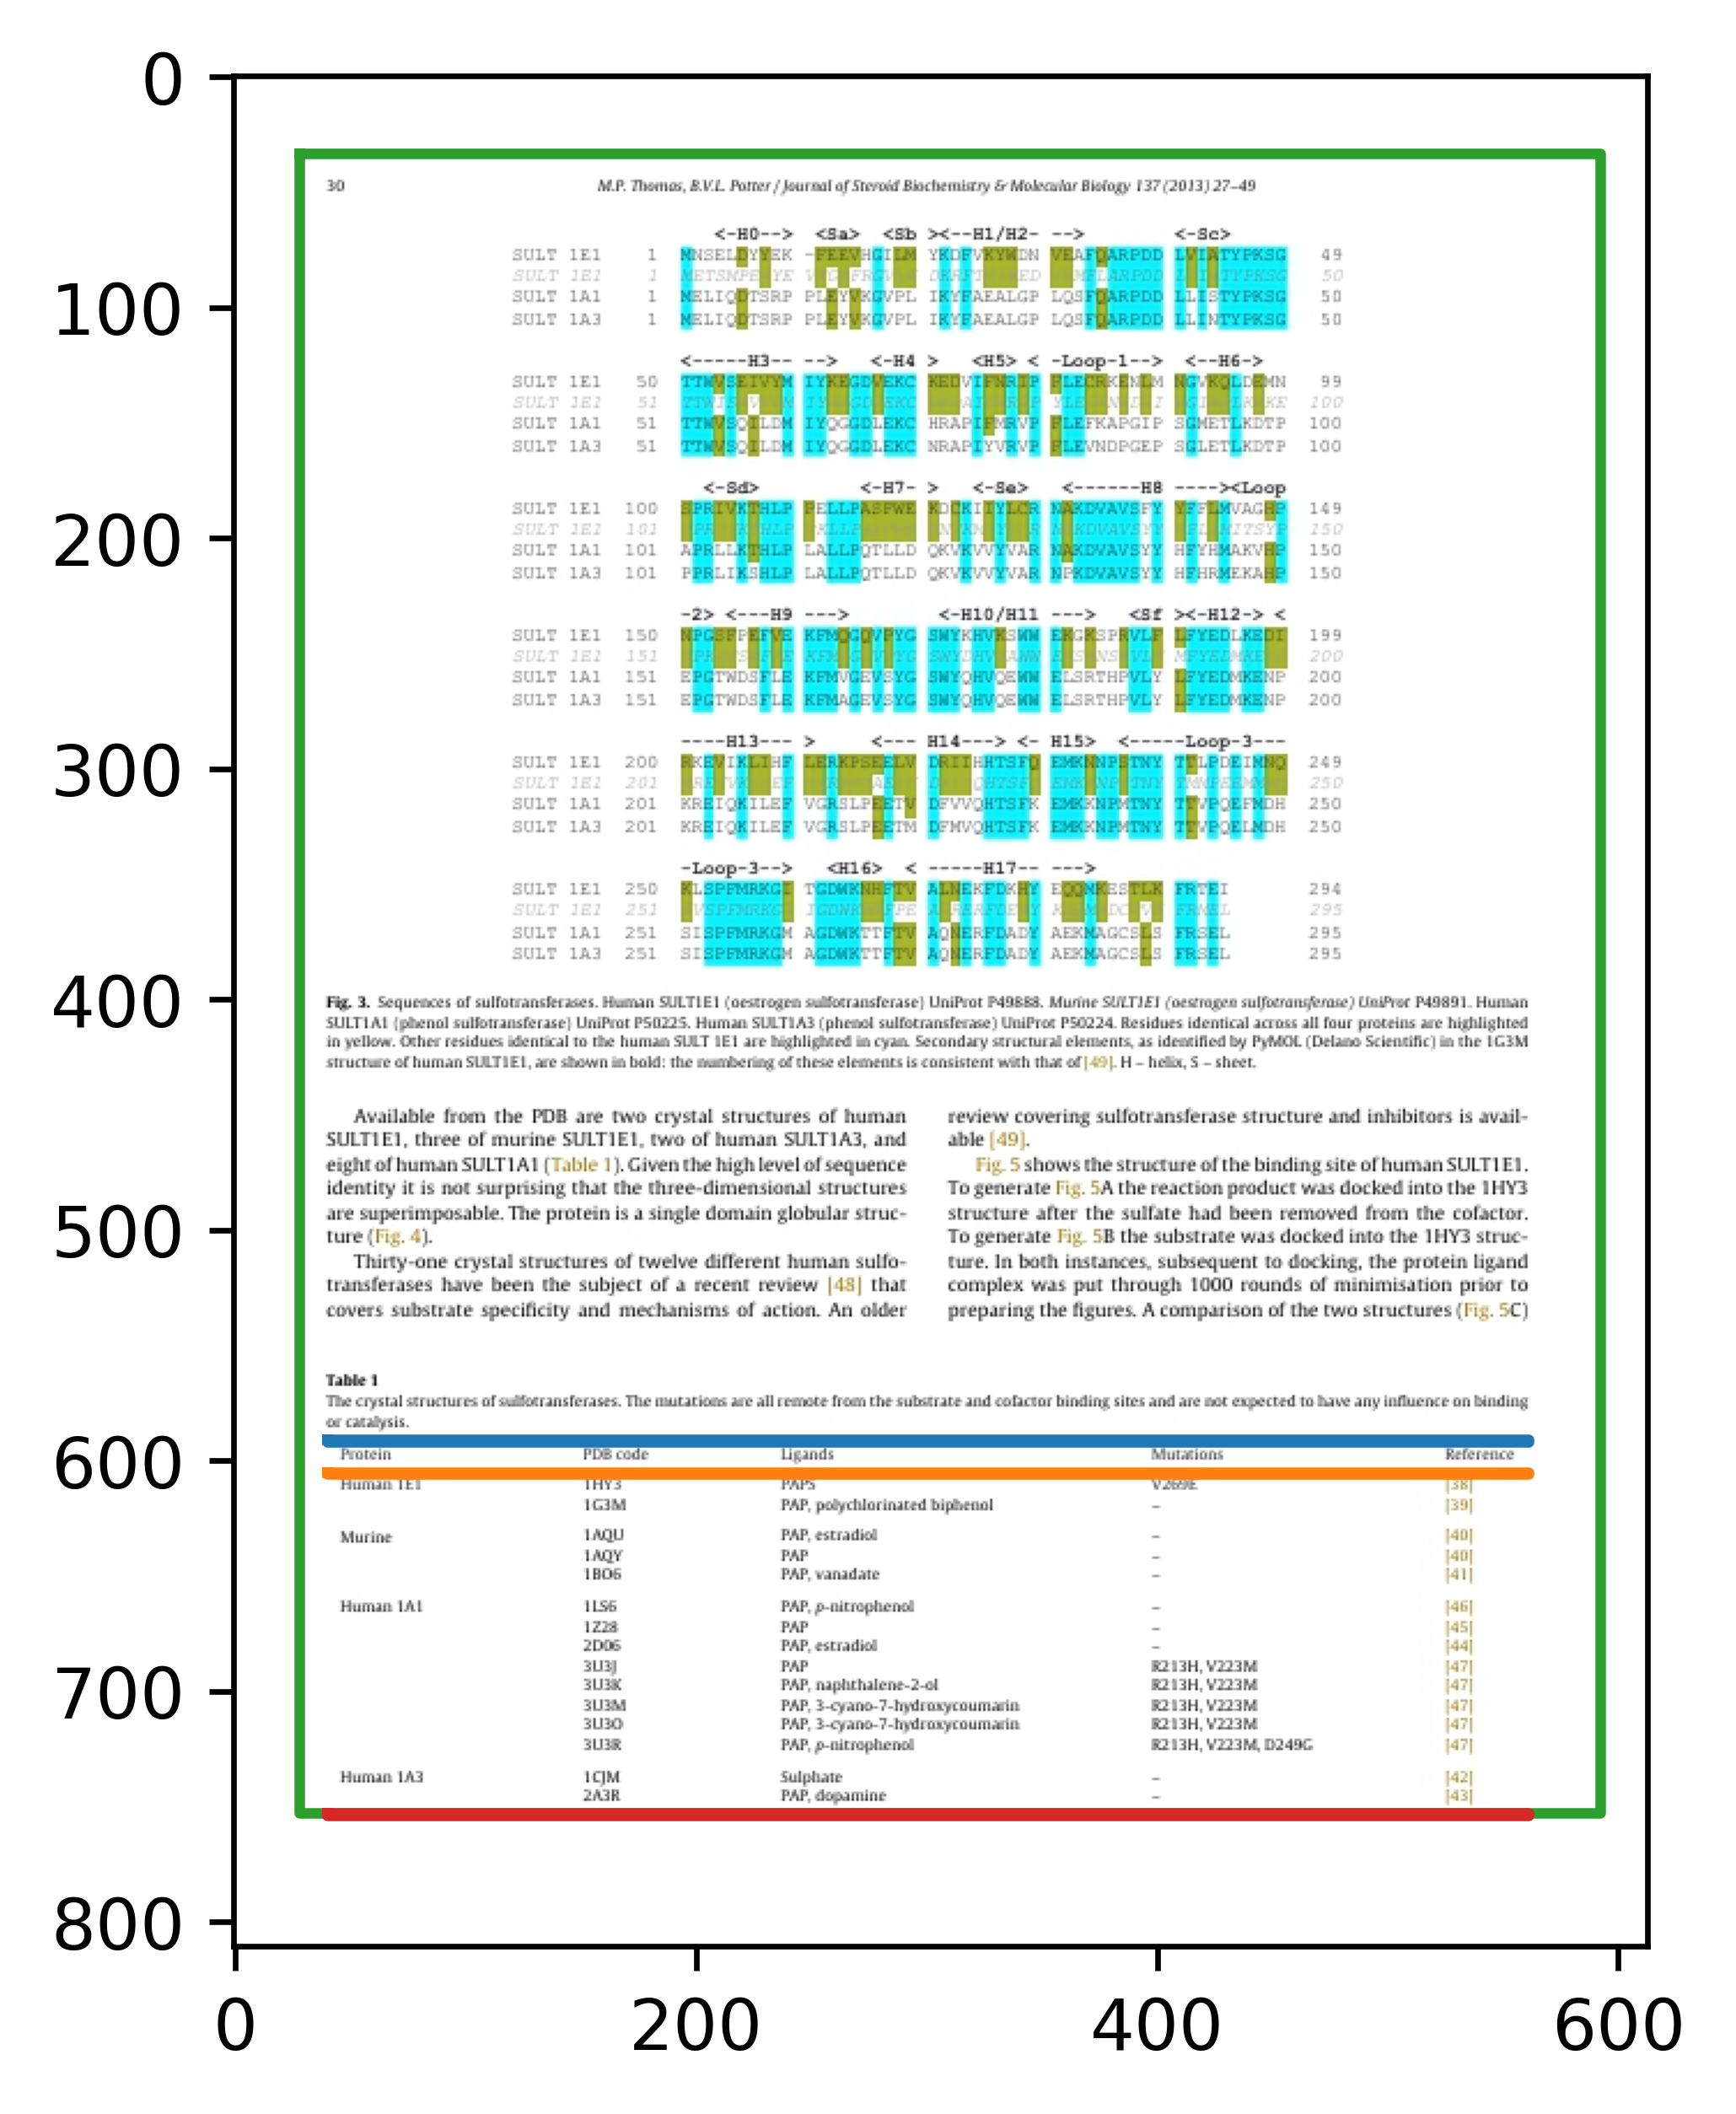

In [214]:
words = t.extract_from_img(image.img)

color = [
    "#000",
    "#00f",
    "#f00",
    "#0f0",
    "#ff0",
    "#f0f",
    "#0ff",
    "#f88",
    "#8f8"
]
plt.figure(dpi=600)
plt.imshow(image.img)
for word in words:
    # c = "#fff"
    # for i, s in enumerate(seg_0_doc):
    #     if is_into_segment( word.segment.get_center(), json.loads(s["json_data"])):
    #         c = color[i] 
    x0 = word.segment.x_top_left
    y0 = word.segment.y_top_left
    x1 = word.segment.x_bottom_right
    y1 = word.segment.y_bottom_right
    # print(word.to_dict())
    plt.plot([x0, x0, x1, x1, x0], [y0, y1, y1, y0, y0])
# for seg in seg_0_doc:
#     json_seg = json.loads(seg["json_data"])
#     x0 = json_seg["x_top_left"]
#     y0 = json_seg["y_top_left"]
#     x1 = json_seg["x_bottom_right"]
#     y1 = json_seg["y_bottom_right"]
#     plt.plot([x0, x0, x1, x1, x0], [y0, y1, y1, y0, y0])

In [71]:
a1 = time.time()

In [12]:
time.time()-a1

20.863629817962646

4 часа 22 мин (21, 18 мин соответственно)

In [66]:
image.img.shape[:2]+image.img.shape[:2]

(811, 613, 811, 613)

In [69]:
help(Word)

Help on class Word in module img_doc.data_structures.document.word:

class Word(builtins.object)
 |  Word(x0: int = 0, y0: int = 0, x1: int = 0, y1: int = 0, text: str = '', bold: float = None)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, x0: int = 0, y0: int = 0, x1: int = 0, y1: int = 0, text: str = '', bold: float = None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  set_bold(self, bold: float)
 |  
 |  set_point_and_size(self, point_and_size: Dict)
 |      x_top_left, y_top_left, width, height
 |  
 |  set_text(self, text: str)
 |  
 |  set_two_points(self, points: Dict)
 |      x_top_left, y_top_left, x_bottom_right, y_bottom_right
 |  
 |  to_dict(self) -> Dict
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)
 |  
 |  ---